<a href="https://colab.research.google.com/github/cxqs/LSTM_01/blob/main/lstm_wind_02min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#数据的颗粒度是小时，时长是一个月
n_in = 168 #历史数量，168个小时，7天，正好一周，这个长度是自定义的，可以修改
n_out = 24 #预测数量，我们需要预测未来一天的变化，所以是24小时
n_features = 1 # 只有一个特征
# n_test = 1
n_val = 0 # 验证的数量
n_epochs = 10 # 迭代的次数

In [3]:
#导入数据，我们用不到时间戳，所以没有对时间特征进行处理
def load_stw_data() -> pd.DataFrame:
    
    df_stw = pd.read_excel('/content/sample_data/dataset/data_wind_02min.xlsx')
    df_stw.columns = ['BillingDate', 'data_wind_02min'] #这里的命名按自己意思来
    
    return df_stw

In [4]:
#MinMaxScaler数据归一化，可以帮助网络模型更快的拟合，稍微有一些提高准确率的效果
def minmaxscaler(data: pd.DataFrame) -> pd.DataFrame:
    
    volume = data.data_wind_02min.values
    volume = volume.reshape(len(volume), 1)
    volume = scaler.fit_transform(volume)# fit_transform函数的输入比较严格，是二维，需要对我们的reshape进行修改
    volume = volume.reshape(len(volume),)    
    data['data_wind_02min'] = volume
        
    return data

In [5]:
#划分训练数据集和验证数据集,这里需要注意的是我么需要预测的数据是不可以出现在训练中的，切记。
def split_data(x, y, n_test: int):
    
    x_train = x[:-n_val-n_out+1]# 验证中的数据，不能出现在训练数据中
    x_val = x[-n_val:]
    y_train = y[:-n_val-n_out+1]
    y_val = y[-n_val:]
    
    return x_train, y_train, x_val, y_val

In [6]:
#划分X和Y，进是X的维度，出是Y的维度
def build_train(train, n_in, n_out):
    
    train = train.drop(["BillingDate"], axis=1)
    X_train, Y_train = [], []
    for i in range(train.shape[0]-n_in-n_out+1):
        X_train.append(np.array(train.iloc[i:i+n_in]))
        Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]["data_wind_02min"]))
        
    return np.array(X_train), np.array(Y_train)

In [7]:
#构建最简单的LSTM
def build_lstm(n_in: int, n_features: int):
    
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(n_in, n_features)))# 输入维度，这是2维的
    model.add(Dropout(0.3))# dropout用来避免过拟合
    model.add(Dense(n_out))# 输出的维度和y的维度一样
    model.compile(optimizer='adam', loss='mae')# 定义优化器和损失函数
    
    return model

In [8]:
#模型拟合
def model_fit(x_train, y_train, x_val, y_val, n_features):
    
    model = build_lstm(
        n_in   = n_in,
        n_features= 1
    )
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=128, verbose=1,  validation_data=(x_val, y_val))
    # batch_size是用来设置多少次更新一次的超参数，在内存运行的时候，不超过自己数据量的情况下，尽量大一点
    # verbose 是否展示训练过程
    # validation_data是验证数据，验证数据是欠拟合还是过拟合，验证的loss比训练的loss大，就是过拟合，要尽早停止训练
    m = model.evaluate(x_val, y_val)
    print(m)
    
    return model

In [9]:
# 调用函数  读取数据和归一化
data = load_stw_data()
scaler = MinMaxScaler(feature_range=(0, 1))
data = minmaxscaler(data)

In [10]:
# 数据划分
data_copy = data.copy()
x, y = build_train(data_copy, n_in, n_out)
x_train, y_train, x_val, y_val = split_data(x, y, n_val)
# 模型搭建和训练
model = build_lstm(n_in, 1)
model = model_fit(x_train, y_train, x_val, y_val, 1)
predict = model.predict(x_val)  

Epoch 1/10
67/67 [==============================] - 8s 91ms/step - loss: 0.1232 - val_loss: 0.0963
Epoch 2/10
67/67 [==============================] - 6s 86ms/step - loss: 0.0961 - val_loss: 0.0906
Epoch 3/10
67/67 [==============================] - 6s 86ms/step - loss: 0.0930 - val_loss: 0.0902
Epoch 4/10
67/67 [==============================] - 6s 87ms/step - loss: 0.0917 - val_loss: 0.0896
Epoch 5/10
67/67 [==============================] - 6s 89ms/step - loss: 0.0909 - val_loss: 0.0893
Epoch 6/10
67/67 [==============================] - 6s 85ms/step - loss: 0.0905 - val_loss: 0.0892
Epoch 7/10
67/67 [==============================] - 6s 87ms/step - loss: 0.0901 - val_loss: 0.0889
Epoch 8/10
67/67 [==============================] - 6s 85ms/step - loss: 0.0899 - val_loss: 0.0889
Epoch 9/10
67/67 [==============================] - 6s 89ms/step - loss: 0.0896 - val_loss: 0.0887
Epoch 10/10
268/268 [==============================] - 4s 14ms/step - loss: 0.0884
0.08840681612491608


In [11]:
# 前面做了归一化，使得数据为0,1之间，这里又做了一次反归一化
# predict = model.predict(x_val)  
validation = scaler.inverse_transform(predict)[0]
validation

array([16.975018, 17.905031, 18.769482, 17.934036, 18.919565, 18.630201,
       19.356676, 19.965338, 19.863035, 19.127056, 20.142355, 18.849096,
       18.937635, 18.76321 , 18.754166, 18.273567, 18.251743, 17.69516 ,
       18.930174, 18.431955, 18.294113, 18.343044, 18.238478, 19.740685],
      dtype=float32)

In [12]:
actual = scaler.inverse_transform(y_val)[0]
actual

array([13., 26., 32., 12., 20., 26., 22.,  9., 15., 33., 15., 45., 11.,
       15., 19., 33., 36., 35., 36., 33., 26., 23., 17., 16.])

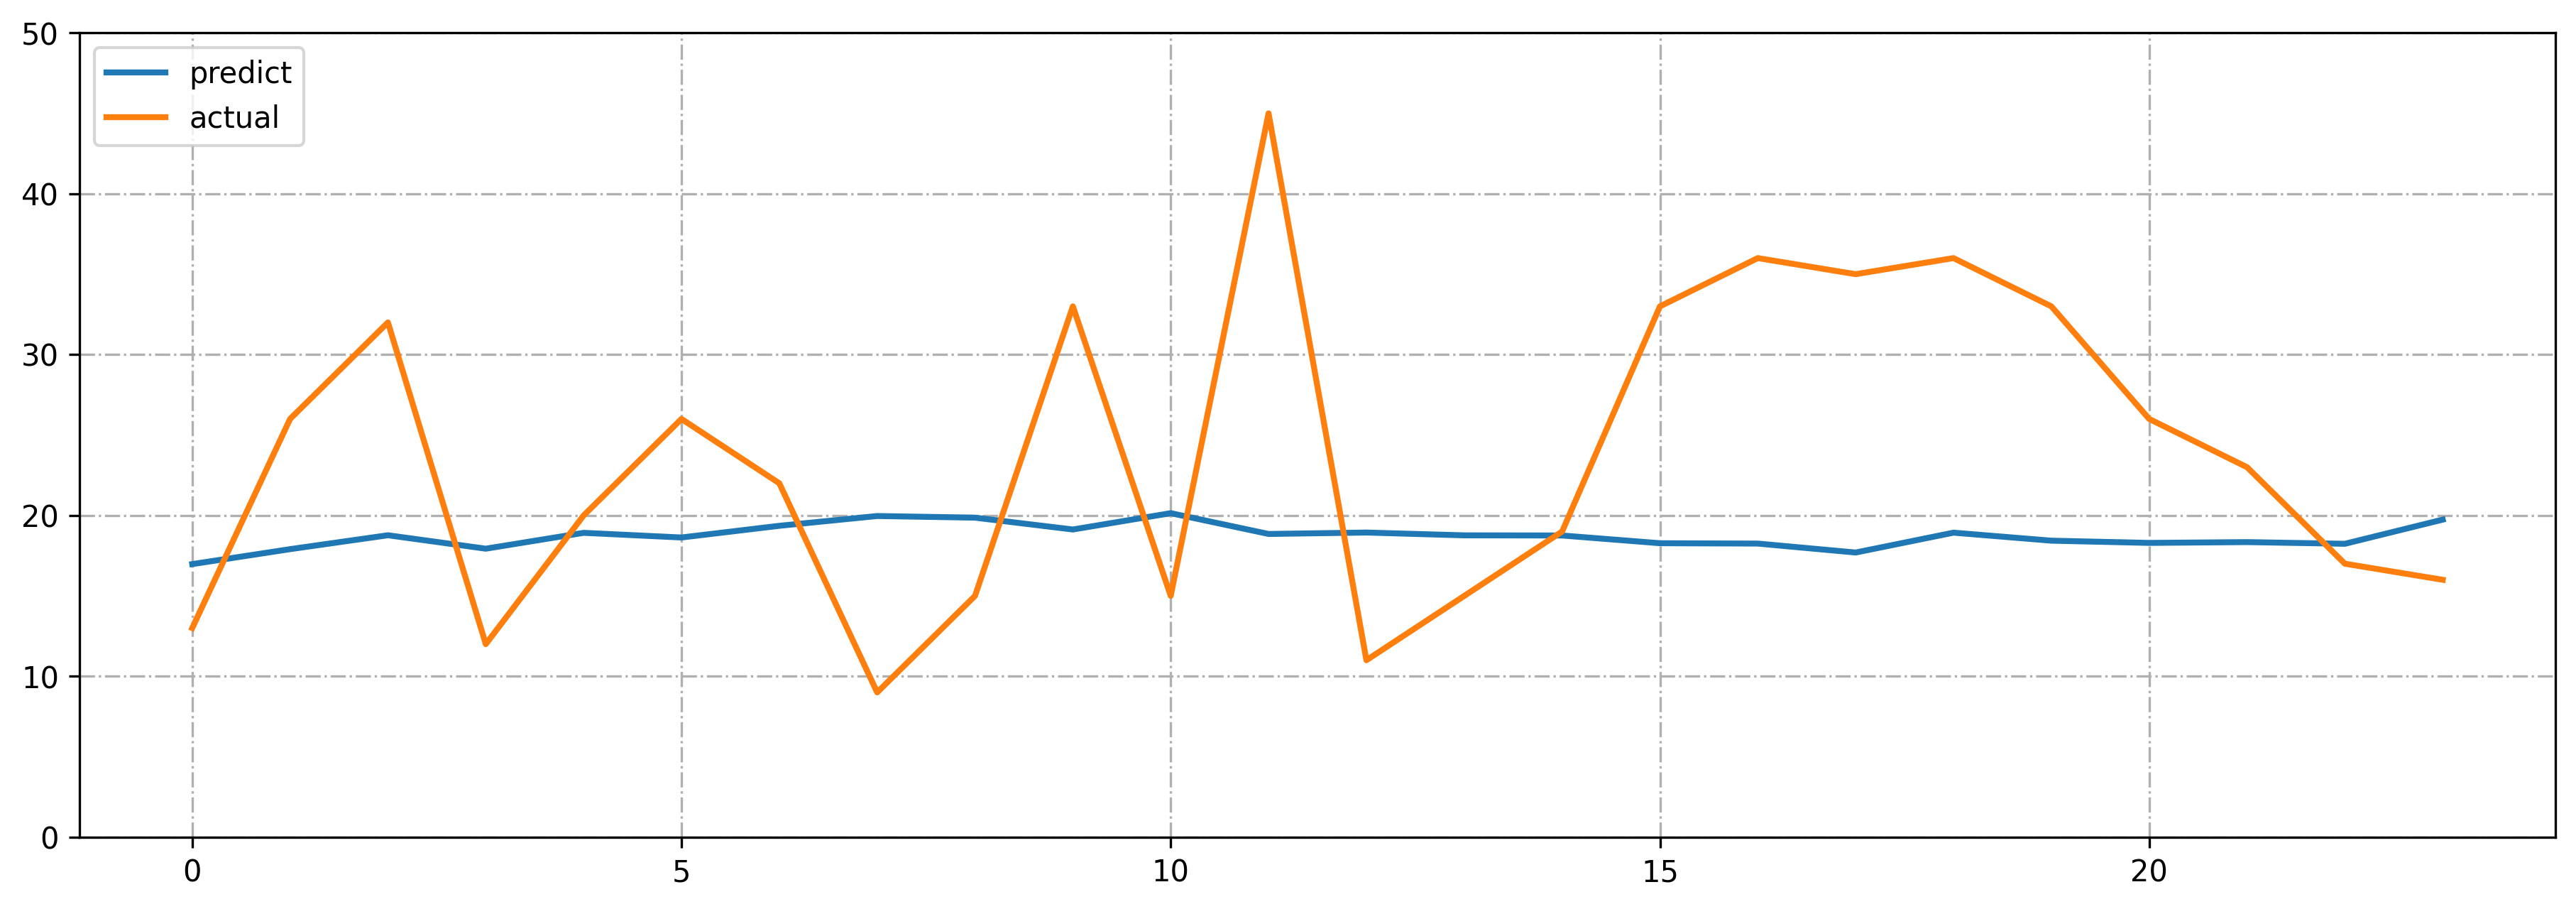

In [13]:
predict = validation
actual = actual
x = [x for x in range(24)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict, linewidth=2.0,label = "predict")
ax.plot(x, actual, linewidth=2.0,label = "actual")
ax.legend(loc=2);
# ax.set_title(bf_name)
plt.ylim((0, 50))
plt.grid(linestyle='-.')
plt.show()

In [14]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predict[i] - actual[i])
    summery += actual[i]
acc = 1 - error/summery
acc

0.6231888045727367